<img src='properati.png' align="center" alt="drawing" width="800"/>



### Grupo 1: *Natali Ferron, Daniela Ichinose, Andres Legorburu, Federico Idoeta, Gonzalo Garcia*
---
### Flujo de trabajo 
<a name="top"></a>
* [1. Analisis de la base de datos](#inicial)
* [2. Extracción de informacion de la columna description](#extraccion)
* [3. Limpieza de los datos](#limpieza)
>[3a.Limpieza de place_name](#limpiezaA)</br>
>[3b.Limpieza de surface](#limpiezaB)</br>
>[3c.Limpieza de price](#limpiezaC)</br>

* [4. Imputacion de los datos faltantes](#imputacion)
>[4a.Imputación de superficie](#impA)</br>
>[4b.Imputación de Ambientes](#impB)</br>
>[4c.Imputación de precio](#impC)</br>
>[4d.Operaciones adicionales](#impD)</br>
>[4e.Reimputación de valores](#impE)</br>
>[4f.Eliminación de outliers en precio y precio por m2](#impF)</br>
>[4g.Imputacion de las columnas latitud y longitud](#impG)

* [5. Analisis descriptivo](#five) 
---

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
# import geopandas as gpd
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px

In [70]:
%config Completer.use_jedi = False
pd.options.mode.chained_assignment = None  # default='warn'

---
<a name="inicial"></a>
## 1.Analisis de la base de datos

In [71]:
#Lectura de datos
data = pd.read_csv('../properatti.csv')

In [72]:
def isnull_explorer(df):
    # explora cada columna del DF y genera un DF con columna, nulos, ratio y percent
    total_values= df.shape[0]
    result=dict()
    for col in df.columns:
        null= df[col].isnull().sum()
        ratio = round(null/total_values,2)
        percent = round(ratio * 100,2)
        result[col]=(null,ratio, percent)
    result_df = pd.DataFrame.from_dict(result, orient='index')
    result_df.rename(columns={0:'null',1:'ratio',2:'percent'}, inplace=True)
    return  result_df.sort_values(by='null', ascending=False)
isnull_explorer(data)

,null,ratio,percent
floor,113321,0.93,93.0
expenses,106958,0.88,88.0
rooms,73830,0.61,61.0
price_usd_per_m2,52603,0.43,43.0
lat-lon,51550,0.43,43.0
lat,51550,0.43,43.0
lon,51550,0.43,43.0
surface_total_in_m2,39328,0.32,32.0
price_per_m2,33562,0.28,28.0
currency,20411,0.17,17.0


### *Del análisis inicial se destaca:*
1. Alto porcentaje de valores nulos en las columnas floor y expenses, las cuales se descartan para el análisis.
2. Bajo porcentaje de nulos en place_name con respecto a latitud y longitud, se decide optimizar place_name con la información de la columna place_with_parent_names y utilizar el resultado como fuente de localización de las propiedades.
3. La columna price_aprox_usd se utilizará como referencia para precios.
4. La columna surface_total se utilizará como referencia para superficie por poseer mejores coeficientes de correlacion, con respecto a precio (que surface_covered).
5. Se observa que la distribucion de precio y superficie tiene sesgo hacia la izquierda, por lo que se tomará la mediana como parametro de imputación.

[Subir](#top)

---
<a name="extraccion"></a>
## 2. Extracción de información de la columna description 
#### *Se realizó una exploración en busca de las palabras más frecuentes (más de 3000), de las mismas se seleccionaron aquellas relacionadas con la descripción de la propiedad, se agruparon por categorías y fueron utilizadas para extraer esa información con regex.*

In [73]:
# Diccionario con los nombres de las columnas (categorías) y sus correspondientes regex
regexA={'price1':'(?P<dolar>\d+\.?\d+)(\s?(us|usd|u\$|u\$d|u\$s))',
           'price2':'(us|usd|u\$|u\$d|u\$s)\s?(?P<dolar>\d+\.?\d+)\s?',
           'surface':'(\d+)(\s?m|m2|mt|mts)',
           'ambientes':'(?P<ambientes>\d)(\s?amb)',
           'rooms':'(?P<dormitorios>\d)(\s?(dorm|habit))'}
regexB= {'monoambiente':'monoamb',
           'contrafrente':'contrafrente',
           'cochera':'(coch|gara)',
           'amenities':'(ameniti|solar|segur|calder|calefac|radian|pileta|pisc)',
           'esp_exterior':'(balc|jard|terra|patio|galer|parril|quinch)',
           'dependencia':'dependen',
           'living':'(livi|comed)',
           'mas_1banio':'(baño|baños|toilet)',
           'store':'local',
           'departamento':'(depart|depto|torr)',
           'casa':'(chale|casa|duplex)',
           'estrenar':'estren'}

In [74]:
# Recibe el DF y devuelve un nuevo df con las columnas de cada nivel de regex 
def extraction_description(data, regexA, regexB):
    df_result=pd.DataFrame()
    final=list()
    serie_description= data.loc[:,'description']
    for index in range(len(serie_description)):
        result=dict()
        result['index_control']=index
        text=serie_description.iloc[index]
        if type(text)==str:
            text=text.lower()
            for key, value in regexA.items():
                exist= re.search(value,text)
                if exist==None:
                    result[key]=0
                else:
                    if key == 'price2':
                        dolars=exist.group(2)
                        dolars=float(dolars)*1000
                        result[key]=dolars
                    elif key=='price1':
                        dolars=exist.group(1)
                        dolars=float(dolars)*1000
                        result[key]=dolars
                    elif key=='surface'or key=='ambientes'or key=='rooms':
                        others=exist.group(1)
                        result[key]=float(others)
                       
            for key2,value2 in regexB.items():
                if re.search(value2,text)==None:
                    result[key2]=0
                else:
                    result[key2]=1
            final.append(result)
        else:
            for key, value in regexA.items():
                result[key]=0
            for key2,value2 in regexB.items():
                result[key2]=0
            final.append(result)
    return pd.DataFrame(final)

# Generacion del dataframe a partir del campo description
df_regex=extraction_description(data,regexA,regexB) 

#### *Limpieza del dataframe generado al aplicar expresiones regulares a la columna description*

In [75]:
# Unifica price en una sola columna
df_regex['price_rgx']=df_regex.apply(lambda x: x.price2 if x.price2>=x.price1 else x.price1, axis=1)  

# Extraccion de los ambientes encontrados, de ser nulos se suman habitaciones, dependencia y living
def logical_rooms(row):
    if row.ambientes!=0:
        return row.ambientes
    elif row['monoambiente']==1:
        return 1
    else:
        return row.rooms+row.dependencia+row.living

df_regex['rooms_rgx']= df_regex.apply(logical_rooms, axis=1)

# Se eliminan los valores de m2 menores que 18 y mayores que 5000
antes=(df_regex.surface>0).sum()
df_regex['surface_rgx']=df_regex.surface.apply(lambda x: x if x>18 and x<5000 else np.NaN)

# Se eliminan las columnas que no son necesarias
df_regex.drop(columns=['index_control', 'price1', 'price2', 'surface', 'ambientes', 'rooms','monoambiente','dependencia', 'living'], inplace=True)

print(f'Hay {(df_regex.price_rgx>0).sum()} valores en price_rgx')
print(f'Hay {(df_regex.rooms_rgx>0).sum()} valores para rooms_rgx')
print(f'Habia {antes} valores de m2, luego de aplicar el filtro (>18m2 y<5000m2) quedan {(df_regex.surface_rgx.notnull()).sum()} valores en surface_rgx')

columnas ={'contrafrente':'al contrafrente', 'cochera':'con cochera', 'amenities':'con amenities(incluye pileta)',\
           'esp_exterior':'con espacios al exterior', 'mas_1banio':'con mas de 1 baño', 'estrenar':'a estrenar'}
for col,text in columnas.items():
    print(f'propiedades {text}: {df_regex[col].sum()}')   

    # Se une el dataframe con la informacion del campo description a la base original con un merge
dataClean=pd.merge(data,df_regex, left_index=True, right_index=True)

Hay 12805 valores en price_rgx
Hay 102332 valores para rooms_rgx
Habia 49934 valores de m2, luego de aplicar el filtro (>18m2 y<5000m2) quedan 41349 valores en surface_rgx
propiedades al contrafrente: 9165
propiedades con cochera: 54930
propiedades con amenities(incluye pileta): 51842
propiedades con espacios al exterior: 89607
propiedades con mas de 1 baño: 84000
propiedades a estrenar: 10668


In [76]:
dataClean.head(3)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,amenities,esp_exterior,mas_1banio,store,departamento,casa,estrenar,price_rgx,rooms_rgx,surface_rgx
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,0,1,1,0,0,1,0,0.0,2.0,NaN
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,1,1,1,0,1,0,1,20000.0,1.0,NaN
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,0,0,1,0,0,0,0,0.0,2.0,NaN


#### *Se exploró completar los valores nulos en precio (price_rgx), superficie (surface_rgx) y ambientes (rooms_rgx) con la información obtenida desde description pero se detectó que no aportan nuevos datos.*
(en instancias posteriores se analizarán cada uno de los campos mencionados).

[Subir](#top)

---
<a name="limpieza"></a>
## 3. Limpieza de los datos

<a name="limpiezaA"></a>
### *3a. Se quitan duplicados y columnas sin información (fc quitar_columnas), limpieza de place_name*

In [77]:
# Se exploran y borran las filas dupicadas
def quitar_duplicados(data):
    data.drop_duplicates(['operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'expenses', 'description', 'title',
       'image_thumbnail'], keep='first', inplace = True)
    data.reset_index(inplace = True, drop=True)
    return data

In [78]:
# Se explora la columna place_name y se completa con place_with_parent_names para que quede la localidad en place name
def limpiar_place_name(data):

    #Creo un DataFrame de las columnas de place
    place = data.loc[:,['place_name','place_with_parent_names']]
    
    #Imprimo los null de place_name antes del cambio
    #print('Cantidad de null en place_name:', data.place_name.isnull().sum())
    
    #Todos los valores NaN en place_name corresponde a Tigre:
    #print(place[place.place_name.isnull()])
    data['place_name']= place['place_name'].fillna("Tigre")
    
    #Imprimo los null de place_name despues del cambio
    #print('Cantidad de null en place_name:', data.place_name.isnull().sum())

    #Patron para separar datos de place_with_parent_names
    pattern_place_name= '\|'
    regex_place_name = re.compile(pattern_place_name)
    resultado = place.place_with_parent_names.apply(lambda x: x if x is np.NaN else regex_place_name.split(x))
    # Creo una lista donde acumulo los resultados de la columna 3 (correspondiente a place_name)
    resultado2 =[]
    for y in range(len(resultado)):
#        if resultado[y][3] != '':
        resultado2.append(resultado[y][3])
#        else:
#            resultado2.append(resultado[y][2])
            
    #Asigno los resultados de resultados2 a la columna place_name
    place['place_name'] = resultado2
    
    #A los campos vacios los completo con NaN
    for j in range(len(place.place_name)):
        if place.loc[j,'place_name']=="":
            place.loc[j,'place_name']=np.NaN
    
    #Asigno los resultados a la columna place_name del df
    data['place_name'] = place['place_name']
    data = data[data.place_name.notnull()]
    data.reset_index(inplace = True, drop=True)
    
    return data

In [79]:
# se quitan las columnas que no contienen informacion relevante
def quitar_columnas(data):
    data.drop(['Unnamed: 0', 'operation', 'country_name',  'geonames_id',  'lat-lon',  'price',  'currency', 
               'price_aprox_local_currency',  'price_usd_per_m2', 'price_per_m2', 'floor', 'properati_url', 
               'expenses','image_thumbnail', 'price_rgx', 'rooms_rgx','store', 'departamento', 'casa',
               'surface_rgx'], axis=1, inplace=True)
    return data

In [80]:
#quito duplicados
dataClean= quitar_duplicados(dataClean) 

#### *Se comprueba que no hay duplicados en el dataframe*

In [81]:
dataClean.duplicated(['operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'description', 'title',
       'image_thumbnail']).value_counts()

False    119982
dtype: int64

In [82]:
#asigno correctamente la columna place_name y elimino los place_names que no se pueden asignar (ej: Cba, Capital Federal)
dataClean = limpiar_place_name(dataClean) 
# se quitan las columnas
dataClean = quitar_columnas(dataClean)

#### *Se comprueba que no hay valores nulos en place_name*

In [83]:
dataClean.place_name.isnull().value_counts()

False    115480
Name: place_name, dtype: int64

In [84]:
#Tamaño del dataset original: 121220 propiedades
dataClean.shape

(115480, 18)

<a name="limpiezaB"></a>
### *3b. Limpieza de surface*
####  *Se observan valores de superficie muy bajos (incluso iguales a 0). Se decide la estrategia de imputarlos con los valores mínimos legales para una vivienda (18 m2) y para un local (6 m2).*

In [85]:
def surface_data_00(data, m2store, m2other):
    #En esta función asigné a una columna nueva el valor de la "superficie total" para poder trabajar -> "superficie_total_in_m2_CLEAN"
    #Verifico que la superficie total sea el mayor valor entre total y cubierta y que si están al revés, use la mayor.    
    data['surface_total_in_m2_CLEAN'] = np.where((data.surface_total_in_m2<=data.surface_covered_in_m2), data.surface_covered_in_m2, data.surface_total_in_m2)

    # reemplazo todos los datos menores a Xm2 por el valor mínimo posible  
    def replace_for(data, store, other):
        if data.property_type=='store' and data.surface_total_in_m2_CLEAN<store:
            return store
        elif data.surface_total_in_m2_CLEAN<other:
            return other
        else:
            return data.surface_total_in_m2_CLEAN
    data['surface_total_in_m2_CLEAN']= data.apply(replace_for,args=(m2store,m2other),axis=1)
    return data

In [86]:
# Se aplica el filtro de superficie con los valores de  6m2 para store y 18m2 para el resto de los tipos de propiedad
dataClean = surface_data_00(dataClean, 6, 18)

#### *Se clasifican a las propiedades de  mas de 5000m2 en una nueva categoría dentro de property_type:"oversized" ya que en su mayoría son naves industriales, fábricas, campos, etc.*

In [87]:
def oversized(data, limit):
    for i in range(len(data)):
        if data.surface_total_in_m2_CLEAN[i]>limit:
            data.property_type[i]='oversized'
    return data

In [88]:
# Se aplica la clasificacion utilizando el limite de 5000 m2
dataClean=oversized(dataClean, 5000)

#### *Se decidió eliminar las filas que corresponden a propiedades agrupadas por place_name con menos de 10 propiedades ya consideramos que no serían representativos para realizar imputaciones posteriores*

In [89]:
dataClean = dataClean[dataClean.groupby(['state_name','place_name'])['place_name'].transform('count').ge(10)]

In [90]:
#Tamaño del dataset original: 121220 propiedades
dataClean.shape

(114647, 19)

<a name="limpiezaC"></a>
### *3c. Limpieza de price*
#### *Se detectaron precios en dólares muy bajos que se consideran errores de carga. A la vez existen valores extremedamente elevados y de muy pocas propiedades que se sospecha tambien puedan ser errores de carga. Se decidió la estrategia de reemplazarlos por NaN con valores de corte tomados en cuenta a partir de la información disponible en el mercado.*

In [91]:
# Funciones que detecta los precios muy bajos y muy altos que se consideran errores de carga y los reemplaza con NaN
def price_too_low(data, price):
    data['price_aprox_usd']=data.price_aprox_usd.apply(lambda x: x if x>=price else np.NaN)
    return data
def overpriced(data, limit):  
    data['price_aprox_usd']=data.price_aprox_usd.apply(lambda x: x if x<=limit else np.NaN)
    return data


In [92]:
dataClean= price_too_low(dataClean, 20000)
dataClean=overpriced(dataClean,3000000)

In [93]:
#Cantidad de registros nulos que quedaron al final de la limpieza por columna
print('Nulos en price: ', dataClean.price_aprox_usd.isnull().sum())

Nulos en price:  18848


[Subir](#top)


---
<a name="imputacion"></a>
## 4. Imputación de datos faltantes en superficie, ambientes y precio.
<a name="impA"></a>
### 4.a Imputación de Superficie

#### 4.a.1. Imputación Superficie: 1er nivel
##### *Se decidió la estrategia de imputar las superficies faltantes usando la mediana agrupada por lugar, tipos de propiedades y subgrupos de precios (5 bines).*

In [94]:
#Imputa con la mediana de la superficie total, agrupando por place_name, property_type y bin_price
def imp_superficie(data, bines): 
    
    data['bin_price'] = pd.qcut(data.price_aprox_usd, bines).astype('category')
    fill_values = data.groupby(['place_name','property_type','bin_price'])['surface_total_in_m2_CLEAN'].median()

    
    fill_values_df = pd.DataFrame(fill_values)
    fill_values_df.reset_index(inplace = True)
    
    data = data.merge(fill_values, on = ['place_name','property_type', 'bin_price'], suffixes = ("", "_median"), how = 'left')
    data.surface_total_in_m2_CLEAN.fillna(data.surface_total_in_m2_CLEAN_median, inplace = True)

    data.drop('surface_total_in_m2_CLEAN_median', axis=1, inplace=True)
    
    print('Nulos en surface_total_in_m2_CLEAN: ', data.surface_total_in_m2_CLEAN.isnull().sum())
        
    return data

In [95]:
dataClean = imp_superficie(dataClean, 5)

Nulos en surface_total_in_m2_CLEAN:  7578


#### 4.a.2. Imputación Superficie: 2do nivel
##### *Luego se realiza una segunda imputación agrupando únicamente por lugar y tipo de propiedad para los datos de precios faltantes.*

In [96]:
#Imputa con la mediana de la superficie total, agrupando por place_name y property_type
def imp_superficie_bis(data): 
    fill_values = data.groupby(['place_name','property_type'])['surface_total_in_m2_CLEAN'].median()

    fill_values_df = pd.DataFrame(fill_values)
    fill_values_df.reset_index(inplace = True)
    
    data = data.merge(fill_values, on = ['place_name','property_type'], suffixes = ("", "_median"), how = 'left')
    data.surface_total_in_m2_CLEAN.fillna(data.surface_total_in_m2_CLEAN_median, inplace = True)

    data.drop('surface_total_in_m2_CLEAN_median', axis=1, inplace=True)
    
    print('Nulos en surface_total_in_m2_CLEAN: ', data.surface_total_in_m2_CLEAN.isnull().sum())
    
    return data

In [97]:
dataClean = imp_superficie_bis(dataClean)

Nulos en surface_total_in_m2_CLEAN:  584


<a name="impB"></a>
### 4.b. Imputación de ambientes
#### 4.b.1. Imputación ambientes: 1er nivel
##### *Se exploraron las columnas title y description utilizando regex para extraer la cantidad de ambientes por propiedad.*

In [98]:
# Se extrae la informacion de la cantidad de ambientes en la columna descripcion y title utilizando regex.
def regex_rooms(data):

    patron = '(\d)( )?(?i)(ambiente|amb)'
    regex = re.compile(patron)

    match = data.description.apply(lambda x: x if x is np.NaN else regex.search(x))
    mask = match.notnull()
    data.loc[mask, "rooms"] = match[mask].apply(lambda x: x if x is np.NaN else x.group(1))

    match_01 = data.title.apply(lambda x: x if x is np.NaN else regex.search(x))
    mask_01 = match_01.notnull()
    data.loc[mask_01, "rooms"] = match_01[mask_01].apply(lambda x: x if x is np.NaN else x.group(1))

    data.rooms = dataClean.rooms.astype('float64')
    
    patron_monoambiente = 'monoambiente'
    regex = re.compile(patron_monoambiente, flags=re.IGNORECASE)

    match = data.description.apply(lambda x: x if x is np.NaN else regex.search(x))
    mask = match.notnull()
    data.loc[mask, "rooms"] = match[mask].apply(lambda x: x if x is np.NaN else 1)

    match_01 = data.title.apply(lambda x: x if x is np.NaN else regex.search(x))
    mask_01 = match_01.notnull()
    data.loc[mask_01, "rooms"] = match_01[mask_01].apply(lambda x: x if x is np.NaN else 1)
    
    data.rooms = dataClean.rooms.astype('float64')
    print('Nulos en regex rooms: ', data.rooms.isnull().sum())

    return data

In [99]:
# Se reemplazan con NaN los valores de rooms mayores a 15
def many_rooms(data, limit):  
    data['rooms']=data.rooms.apply(lambda x: x if x<=limit else np.NaN)
    print('Nulos en many rooms: ', data.rooms.isnull().sum())
    return data

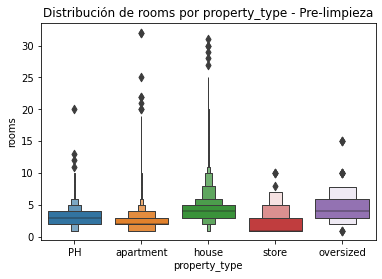

In [100]:
sns.boxenplot(data=dataClean, y='rooms', x='property_type')
plt.title('Distribución de rooms por property_type - Pre-limpieza');

In [101]:
dataClean = regex_rooms(dataClean)
#Según lo analizado en el mercado es poco probable que una propiedad tenga más de 15 ambientes. 
dataClean = many_rooms(dataClean,15)

Nulos en regex rooms:  43206
Nulos en many rooms:  43273


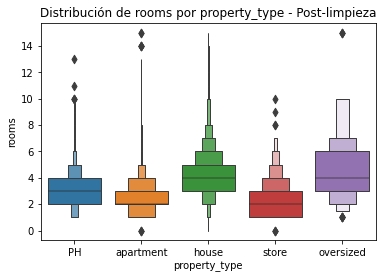

In [102]:
sns.boxenplot(data=dataClean, y='rooms', x='property_type')
plt.title('Distribución de rooms por property_type - Post-limpieza');

#### 4.b.2. Imputación ambientes: 2do nivel. 
##### *Se decidió la estrategia de imputar los ambientes faltantes utilizando la mediana agrupada por lugar, tipos de propiedades y subgrupos de superficie (5 bines).*

In [103]:
#Imputa con la mediana del campo rooms, agrupando por place_name, property_type y bin_sup
def imp_rooms(data, bines): 
    data['bin_sup'] = pd.qcut(data.surface_total_in_m2_CLEAN, bines).astype('category')
    fill_values = data.groupby(['place_name', 'property_type', 'bin_sup']).rooms.median().round(0)
    fill_values_df = pd.DataFrame(fill_values)
    fill_values_df.reset_index(inplace = True)
    data_2 = data.merge(fill_values_df, on = ['place_name', 'property_type', 'bin_sup'], suffixes = ("", "_median"), how = 'left')
    data_2.rooms.fillna(data_2.rooms_median, inplace = True)
    data_2.drop('rooms_median', axis=1, inplace=True)

    print('Nulos en rooms: ', data_2.rooms.isnull().sum())

    return data_2

In [104]:
dataClean = imp_rooms(dataClean, 5)

Nulos en rooms:  2633


[Subir](#top)

<a name="impC"></a>
### 4.c. Imputación de precio
##### Se realizan tres niveles de imputación con diferentes grados de agrupación.

#### 4.c.1. Imputación de Precio: 1er nivel
##### *Se decidió la estrategia de imputar los precios faltantes usando la mediana agrupada por lugar, tipos de propiedades, subgrupos de superficie (5 bines) y ambientes.*

In [105]:
#Imputa con la mediana del precio total, agrupando por place_name, property_type, bin_sup y rooms.
def imp_precio_rooms(data, bines): 
    data['bin_sup'] = pd.qcut(data.surface_total_in_m2_CLEAN, bines).astype('category')
    fill_values = data.groupby(['place_name', 'property_type', 'bin_sup', 'rooms']).price_aprox_usd.median().round(2)

    fill_values_df = pd.DataFrame(fill_values)
    fill_values_df.reset_index(inplace = True)

    data_2 = data.merge(fill_values_df, on = ['place_name', 'property_type', 'bin_sup', 'rooms'], suffixes = ("", "_median"), how = 'left')

    data_2.price_aprox_usd.fillna(data_2.price_aprox_usd_median, inplace = True)

    data_2.drop('price_aprox_usd_median', axis=1, inplace=True)

    print('Nulos en price_aprox_usd: ', data_2.price_aprox_usd.isnull().sum())

    return data_2

In [106]:
dataClean = imp_precio_rooms(dataClean,5)

Nulos en price_aprox_usd:  1934


#### 4.c.2. Imputación de Precio: 2do nivel
##### *Luego para las propiedades que persisten sin datos de precio ni ambientes, se decide imputar agrupando por lugar, tipos de propiedades y subgrupos de superficie (5 bines).*

In [107]:
#Imputa con la mediana del precio total, agrupando por place_name, property_type y bin_sup
def imp_precio(data, bines): 
    data['bin_sup'] = pd.qcut(data.surface_total_in_m2_CLEAN, bines).astype('category')
   
    fill_values = data.groupby(['place_name', 'property_type', 'bin_sup']).price_aprox_usd.median().round(2)
    fill_values_df = pd.DataFrame(fill_values)
    fill_values_df.reset_index(inplace = True)

    data_2 = data.merge(fill_values_df, on = ['place_name', 'property_type', 'bin_sup'], suffixes = ("", "_median"), how = 'left')
    data_2.price_aprox_usd.fillna(data_2.price_aprox_usd_median, inplace = True)
    data_2.drop('price_aprox_usd_median', axis=1, inplace=True)

    print('Nulos en price_aprox_usd: ', data_2.price_aprox_usd.isnull().sum())

    return data_2

In [108]:
dataClean = imp_precio(dataClean,5) 

Nulos en price_aprox_usd:  713


#### 4.c.3 Imputación de Precio: 3er nivel
##### *Finalmente se realiza una tercera imputación de precios faltantes agrupando por lugar y tipos de propiedades*

In [109]:
#Imputa con la mediana del precio, agrupando por place_name y property_type
def imp_precio_bis(data): 
   
    fill_values = data.groupby(['place_name', 'property_type']).price_aprox_usd.median().round(2)
    fill_values_df = pd.DataFrame(fill_values)
    fill_values_df.reset_index(inplace = True)

    data_2 = data.merge(fill_values_df, on = ['place_name', 'property_type'], suffixes = ("", "_median"), how = 'left')
    data_2.price_aprox_usd.fillna(data_2.price_aprox_usd_median, inplace = True)
    data_2.drop('price_aprox_usd_median', axis=1, inplace=True)

    print('Nulos en price_aprox_usd: ', data_2.price_aprox_usd.isnull().sum())

    return data_2

In [110]:
dataClean = imp_precio_bis(dataClean) 

Nulos en price_aprox_usd:  268


[Subir](#top)

<a name="impD"></a>
### 4.d. Operaciones adicionales

#### *4.d.1 Se eliminan los nulos en superficie y precio que no se pudieron imputar por falta de datos*

In [111]:
def delete_null_SupPrice(data):
    data = data[(data.surface_total_in_m2_CLEAN.notnull())&(data.price_aprox_usd.notnull())]
    data.reset_index(inplace=True, drop=True)
    return data
dataClean = delete_null_SupPrice(dataClean)

#### *4.d.2 Se genera la columna precio por metro cuadrado*

In [112]:
dataClean['price_m2_calc_supTotal'] = dataClean.price_aprox_usd / dataClean.surface_total_in_m2_CLEAN

#### *4.d.3 Se reemplazan por valores nulos los precios totales y por metro cuadrado de aquellas propiedades con precio por metro cuadrado mayor a:*
* 10.000 u\$d\/m2 para AMBA</br>
* 6.000 u\$d\/m2 para fuera de AMBA


In [113]:
def high_ppsqm(data, limitAMBA, limitOutAMBA):
    for i in range(len(data)):
        if (data.state_name[i]=='Capital Federal') or (data.state_name[i]=='Bs.As. G.B.A. Zona Sur') or (data.state_name[i]=='Bs.As. G.B.A. Zona Norte') or (data.state_name[i]=='Bs.As. G.B.A. Zona Oeste'):
            if data.price_m2_calc_supTotal[i] > limitAMBA:
                data.price_m2_calc_supTotal[i] = np.NaN
                data.price_aprox_usd[i] = np.NaN
        else:
            if data.price_m2_calc_supTotal[i] > limitOutAMBA:
                data.price_m2_calc_supTotal[i] = np.NaN
                data.price_aprox_usd[i] = np.NaN
    
    print('Nulos en price_aprox_usd: ', data.price_aprox_usd.isnull().sum())
    return data

In [114]:
dataClean = high_ppsqm(dataClean, 10000, 6000)

Nulos en price_aprox_usd:  1079


[Subir](#top)

<a name="impE"></a>
### 4.e. Reimputación de valores nulos

##### *Se vuelven a imputar los datos clasificados en la etapa anterior con las funciones de superficie, ambientes y precio*

In [115]:
dataClean = imp_precio(imp_rooms(imp_superficie(dataClean,5),5),5) 

Nulos en surface_total_in_m2_CLEAN:  0
Nulos en rooms:  2246
Nulos en price_aprox_usd:  26


[Subir](#top)

<a name="impF"></a>
### 4.f. Aplicación de outliers
##### *Se aplicó una función que elimina los valores outliers de precio por metro cuadrado agrupando por lugar y tipos de propiedades tomando como criterio el intervalo IQR*

In [116]:
def outliers_ppsqm(data): 
    data = data.drop(columns= 'price_m2_calc_supTotal') 
    data['price_m2_calc_supTotal']= data['price_aprox_usd']/data['surface_total_in_m2_CLEAN']
    
    q1 = data.groupby(['place_name', 'property_type'])['price_m2_calc_supTotal'].quantile(0.25)
    q2 = data.groupby(['place_name', 'property_type'])['price_m2_calc_supTotal'].quantile(0.5)
    q3 = data.groupby(['place_name', 'property_type'])['price_m2_calc_supTotal'].quantile(0.75)
    q4 = data.groupby(['place_name', 'property_type'])['price_m2_calc_supTotal'].quantile(1.)
  
    limite_sup = q3 + 1.5*(q3-q1)
    
    limite_inf = q1 - 1.5*(q3-q1)
    
    result=[]
    prueba=data.loc[:,['place_name','property_type','price_m2_calc_supTotal']]
    for i in range(len(prueba)):
        try:
            result.append((prueba.price_m2_calc_supTotal[i]<limite_sup[prueba.place_name[i], prueba.property_type[i]])&(prueba.price_m2_calc_supTotal[i]>limite_inf[prueba.place_name[i], prueba.property_type[i]]))
        except:
            result.append(False)
    
    mask = np.array(result)
    print('Hay: ', (mask.shape-mask.sum())[0], 'outliers')

    data = data[mask]
    data.reset_index(inplace=True, drop=True)
    print('Nulos en place_name: ', data.place_name.isnull().sum())
    print('Nulos en surface_total_in_m2_CLEAN: ', data.surface_total_in_m2_CLEAN.isnull().sum())
    print('Nulos en price_aprox_usd: ', data.price_aprox_usd.isnull().sum())
    print('Nulos en price_m2_calc_supTotal: ', data.price_m2_calc_supTotal.isnull().sum())
    
    return data

In [117]:
dataClean = outliers_ppsqm(dataClean)

Hay:  6193 outliers
Nulos en place_name:  0
Nulos en surface_total_in_m2_CLEAN:  0
Nulos en price_aprox_usd:  0
Nulos en price_m2_calc_supTotal:  0


[Subir](#top)

<a name="impG"></a>
### 4.g. Imputación de las columnas latitud y longitud
##### *Se decidió realizar la imputación de latitud y longitud, utilizando la mediana condicionada por los datos del lugar.*

In [118]:

def imp_lat_lon(data):
    fill_values = data.groupby(['place_name']).lat.median().round(2)
    fill_values_df = pd.DataFrame(fill_values)
    fill_values_df.reset_index(inplace = True)

    data_2 = data.merge(fill_values_df, on = ['place_name'], suffixes = ("", "_median"), how = 'left')
    data_2.lat.fillna(data_2.lat_median, inplace = True)
    data_2.drop('lat_median', axis=1, inplace=True)

    fill_values = data.groupby(['place_name']).lon.median().round(2)
    fill_values_df = pd.DataFrame(fill_values)
    fill_values_df.reset_index(inplace = True)

    data_2 = data_2.merge(fill_values_df, on = ['place_name'], suffixes = ("", "_median"), how = 'left')
    data_2.lon.fillna(data_2.lon_median, inplace = True)
    data_2.drop('lon_median', axis=1, inplace=True)
    
    print('Nulos en lat: ', data_2.lat.isnull().sum())
    print('Nulos en lon: ', data_2.lon.isnull().sum())

    return data_2

In [119]:
dataClean = imp_lat_lon(dataClean)

Nulos en lat:  403
Nulos en lon:  403


In [120]:
# geo_properati = gpd.GeoDataFrame(dataClean,geometry=gpd.points_from_xy(dataClean.lon, dataClean.lat))

In [121]:
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# geo_argentina = world[world.name=='Argentina']

In [122]:
# def graficar(p_ciudad, p_pais):
#    """Grafica ciudades sobre el mapa del pais"""
#    
#    ax = p_pais.plot(color='white', edgecolor='black')
#
#    # Sobre las ciudades superpone el mapa del país
#    p_ciudad.plot(ax=ax, color='red')

# plt.show()

In [123]:
# graficar(geo_properati,geo_argentina)

[Subir](#top)

<a name="five"></a>
## 5. Análisis descriptivo, coeficientes de correlación entre precio y superficie.
##### *Se calcularon los coeficientes de correlación para la información agrupada por place_name y property_type.*


In [124]:
def coef_pear(data, places, props, col1, col2):
    #data: dataframe, place: array, prop: array, col1: string, col2: string (col1 y col2 serían las variables del coeficiente)
    result=[]
    for place in places:
        for prop in props:
            pearson = data[(data.property_type==prop)&(data.place_name==place)].corr(method='pearson')
            result.append((place, prop, data.place_name[(data.property_type==prop)&(data.place_name==place)].count(), pearson.loc[col1, col2]))
    result_data = pd.DataFrame(result, columns=['place_name', 'property_type', 'nr_of_properties', 'pearson'])
    return result_data

In [ ]:
#Se utiliza como muestra Capital Federal a modo de ejemplo. Se puede reemplazar por otro state_name.
property_type = dataClean.property_type.unique()
place_name = dataClean[dataClean.state_name=='Capital Federal'].place_name.unique()
coef_dataClean = coef_pear(dataClean, place_name, property_type, 'surface_total_in_m2_CLEAN', 'price_aprox_usd')

In [ ]:
coef_dataClean.head(3)

##### *Se calcularon los coeficientes de correlación promedio según lugar(state_name y place_name), tipos de propiedades (excluyendo oversized) y, para que sea representativo, aquellos grupos que contienen mas de 20 propiedades.*

In [ ]:
coef_dataClean[(coef_dataClean.property_type!='oversized')&(coef_dataClean['nr_of_properties']>20)].pearson.abs().mean() 

[Subir](#top)

### Gráficos

In [ ]:
nulos = pd.DataFrame(np.round(data.isnull().sum()*100/data.shape[0],2).sort_values(ascending=False), columns=['Porcentaje_de_nulos'])
nulos = nulos[nulos.index!='Unnamed: 0']

fig = plt.gcf()
ax = plt.axes()

fig.set_size_inches( 16, 10)
ax.set(xlim=(0, 100))
sns.barplot(x="Porcentaje_de_nulos", y=nulos.index, data=nulos, palette= 'pastel')
plt.title('Porcentaje de datos faltantes en el dataset inicial');

In [ ]:
nulos_finales = pd.DataFrame(np.round(dataClean.isnull().sum()*100/dataClean.shape[0],2).sort_values(ascending=False), columns=['Porcentaje_de_nulos'])
nulos_finales = nulos_finales.drop(['surface_total_in_m2', 'surface_covered_in_m2'])

fig = plt.gcf()
fig.set_size_inches( 16, 10)
ax = plt.axes()

ax.set(xlim=(0, 100))
sns.barplot(x="Porcentaje_de_nulos", y=nulos_finales.index, data=nulos_finales, palette= 'pastel')
plt.title('Porcentaje de datos faltantes en el dataset final');

In [ ]:
plot_to_graph = dataClean[['place_name','state_name']].groupby(['state_name'])['place_name'] \
                .count() \
                .reset_index(name='count') \
                .sort_values(['count'], ascending=False)

In [ ]:
# Set notebook mode to work in offline
pyo.init_notebook_mode()

fig = px.bar(data_frame = plot_to_graph.iloc[0:7], y='state_name',
x='count', color = 'state_name',
title = 'Distribución de propiedades por \"state_name\" (Top 7)', orientation = 'h')
fig.show()

In [ ]:
plot_to_graph_1 = dataClean[['property_type']].groupby(['property_type'])['property_type'] \
                .count() \
                .reset_index(name='count') \
                .sort_values(['count'], ascending=False)

# Set notebook mode to work in offline
pyo.init_notebook_mode()

fig = px.bar(data_frame = plot_to_graph_1.iloc[0:6], y='property_type',
x='count', color = 'property_type',
title = 'Distribución de propiedades por tipo', orientation = 'h')
fig.show()

In [ ]:
fig = plt.gcf()
fig.set_size_inches(20, 10)

sns.boxenplot(data=dataClean, y='price_m2_calc_supTotal', x='property_type');

In [ ]:
#dataClean.to_csv('properati_final.csv')

In [ ]:
dataClean.drop(['lat', 'lon', 'surface_total_in_m2', 'surface_covered_in_m2','description', 'title', 'bin_price', 'bin_sup', 'place_with_parent_names'], axis = 1, inplace = True )
data_CABA = dataClean.loc[dataClean.state_name == 'Capital Federal']
data_CABA.to_csv('properati_CABA.csv')